In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD, PCA
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.cluster import KMeans
import seaborn as sns
from IPython.display import display
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from wordcloud import WordCloud
import matplotlib.cm as cm



## data loading and preprocessing

In [22]:
df = pd.read_csv('../data/new_pivot_table.csv')
df.drop('moving:moving', inplace= True, axis= 1)

user_list = df.imsi
df.set_index('imsi', inplace= True)
df.fillna(0, inplace= True)
df = df.astype(int)
display(df.head())

print("Raw data shape:", df.shape)


'''filter out useless feature (Silhouette scroe is better off as opposed including all features)'''
df.drop('empty:empty', axis= 1, inplace= True)
tmp = (df.sum() / np.sum(df.sum())).sort_values(ascending=False)
selected_poi = tmp.index[:100]
del tmp

df = df.loc[:, selected_poi]
print("After poi selection data shape:", df.shape)
print(f"unique user count: {len(user_list)} and poi feauture count: {df.shape[1]}")
display(df.head())
columns = df.columns


scaler = StandardScaler()
standardized_df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
standardized_df.index = list(df.index)

print('After standardization')
display(standardized_df.head())


doc2vec_df = df.copy()
for c in columns:
    doc2vec_df[c] = doc2vec_df[c].apply(lambda x:c if x> 0 else 0 )
display(doc2vec_df.head())


,aerialway:gondola,aerialway:pylon,aerialway:station,aerialway:zip_line,aeroway:aerodrome,aeroway:apron,aeroway:helipad,aeroway:parking_position,aeroway:runway,aeroway:taxiway,...,tourism:hotel,tourism:information,tourism:motel,tourism:theme_park,tourism:viewpoint,tourism:yes,waterway:canal,waterway:ditch,waterway:drain,waterway:stream
imsi,,,,,,,,,,,,,,,,,,,,,
510019310255406,0,0,0,0,0,0,0,0,0,0,...,44,0,0,0,0,32,0,0,0,4
510018960283345,0,0,0,0,0,0,0,0,0,0,...,39,6,5,0,0,6,1,0,0,42
510019360017398,0,0,0,0,0,0,1,0,0,0,...,48,14,1,0,0,23,0,0,0,4
510019860238990,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,0,3
510011610574037,0,2,0,0,0,0,0,0,0,0,...,29,0,0,0,0,0,0,0,0,1


Raw data shape: (2140, 445)
After poi selection data shape: (2140, 100)
unique user count: 2140 and poi feauture count: 100


,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,...,tourism:yes,amenity:fire_station,emergency:yes,sport:multi,highway:motorway,shop:dry_cleaning,building:retail,landuse:industrial,sport:tennis,tourism:information
imsi,,,,,,,,,,,,,,,,,,,,,
510019310255406,64,50,54,52,51,50,54,56,51,45,...,32,5,0,34,1,0,0,2,0,0
510018960283345,95,69,89,90,63,77,87,70,52,91,...,6,6,0,0,0,6,0,7,0,6
510019360017398,52,50,42,52,28,55,41,56,54,28,...,23,1,0,0,0,5,0,2,2,14
510019860238990,80,61,74,72,43,79,73,70,67,68,...,1,2,2,0,0,0,0,0,8,0
510011610574037,91,52,36,32,47,49,36,45,46,18,...,0,0,13,3,0,0,2,1,0,0


After standardization


,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,...,tourism:yes,amenity:fire_station,emergency:yes,sport:multi,highway:motorway,shop:dry_cleaning,building:retail,landuse:industrial,sport:tennis,tourism:information
510019310255406,-0.006644,-0.109048,0.118947,0.068257,0.076445,0.083087,0.241784,0.496888,0.351724,0.183380,...,3.329704,0.158708,-0.409300,3.747305,-0.237253,-0.345468,-0.386661,-0.145834,-0.382539,-0.319956
510018960283345,1.452781,0.773318,1.548302,1.583578,0.595925,1.236282,1.570667,1.106153,0.397915,2.119448,...,0.286291,0.267810,-0.409300,-0.422990,-0.337515,0.285515,-0.386661,0.465618,-0.382539,0.282601
510019360017398,-0.571582,-0.109048,-0.371117,0.068257,-0.919225,0.296642,-0.281715,0.496888,0.490298,-0.532124,...,2.276215,-0.277700,-0.409300,-0.422990,-0.337515,0.180351,-0.386661,-0.145834,-0.142435,1.086009
510019860238990,0.746608,0.401795,0.935721,0.865794,-0.269875,1.321704,1.006899,1.106153,1.090787,1.151414,...,-0.298981,-0.168598,-0.172089,-0.422990,-0.337515,-0.345468,-0.386661,-0.390415,0.577876,-0.319956
510011610574037,1.264468,-0.016167,-0.616149,-0.729281,-0.096715,0.040376,-0.483061,0.018180,0.120767,-0.953008,...,-0.416035,-0.386803,1.132573,-0.055023,-0.337515,-0.345468,-0.150110,-0.268124,-0.382539,-0.319956


,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,...,tourism:yes,amenity:fire_station,emergency:yes,sport:multi,highway:motorway,shop:dry_cleaning,building:retail,landuse:industrial,sport:tennis,tourism:information
imsi,,,,,,,,,,,,,,,,,,,,,
510019310255406,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,...,tourism:yes,amenity:fire_station,0,sport:multi,highway:motorway,0,0,landuse:industrial,0,0
510018960283345,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,...,tourism:yes,amenity:fire_station,0,0,0,shop:dry_cleaning,0,landuse:industrial,0,tourism:information
510019360017398,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,...,tourism:yes,amenity:fire_station,0,0,0,shop:dry_cleaning,0,landuse:industrial,sport:tennis,tourism:information
510019860238990,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,...,tourism:yes,amenity:fire_station,emergency:yes,0,0,0,0,0,sport:tennis,0
510011610574037,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,...,0,0,emergency:yes,sport:multi,0,0,building:retail,landuse:industrial,0,0


## input vectorize

### pca vectorization

1. __Finding the optimal number of components__

In [23]:
df = standardized_df

original input shape: (2140, 100)


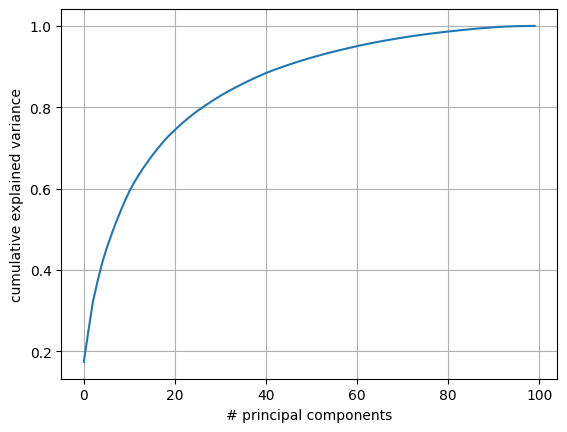

In [24]:
poi_count_array = df.values
print('original input shape:', poi_count_array.shape)

decomposer = TruncatedSVD(n_components = 100, n_iter = 60)
decomposer.fit(poi_count_array)
cum_explained_var_ratio = np.cumsum(decomposer.explained_variance_ratio_)
del decomposer

plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance')
plt.grid()


2. __Use 30 as number of components for fitting (explained 80~90 percent of variance)__

In [6]:
poi_count_array = df.values
print('original input shape:', poi_count_array.shape)

decomposer = TruncatedSVD(n_components = 30, n_iter = 60)
decomposer.fit(poi_count_array)
print('total explained variance ratio: ', np.sum(decomposer.explained_variance_ratio_))
pca_vectors = decomposer.transform(poi_count_array)
print('vectorized shape:', pca_vectors.shape)
poi_to_pca_vector = decomposer.components_.T
print('poi to pca vector shape:', poi_to_pca_vector.shape)


original input shape: (2140, 100)
total explained variance ratio:  0.8212408844489141
vectorized shape: (2140, 30)
poi to pca vector shape: (100, 30)


3. __Vector explanation__

In [226]:
poi_similarity_df = pd.DataFrame(cosine_similarity(poi_to_pca_vector), columns=columns)
poi_similarity_df.index = list(columns)
top_num = 10
# poi_to_see = "amenity:bar"
# poi_to_see = "sport:tennis"
poi_to_see = "building:mosque"
print("target poi:", poi_to_see)
most_similar = list(poi_similarity_df[poi_similarity_df.index == poi_to_see].T.sort_values(by = poi_to_see, ascending= False).head(top_num + 1).index)[1:]
print(f'top {top_num} most similar:', most_similar)
reverse_similar = list(poi_similarity_df[poi_similarity_df.index == poi_to_see].T.sort_values(by = poi_to_see, ascending= False).tail(top_num).index)
print(f'top {top_num} reverse similar:', reverse_similar)

# sport:tennis: 3 vs 2


target poi: building:mosque
top 10 most similar: ['amenity:place_of_worship', 'highway:living_street', 'sport:futsal', 'leisure:pitch', 'building:office', 'highway:path', 'amenity:park', 'landuse:pumping_station', 'highway:footway', 'shop:laundry']
top 10 reverse similar: ['amenity:atm', 'amenity:restaurant', 'office:diplomatic', 'power:substation', 'office:educational_institution', 'building:museum', 'building:residential', 'amenity:bar', 'highway:primary', 'moving:moving']


In [228]:
similar_poi = model.wv.most_similar(poi_to_see)
print("top most similar")
display(similar_poi)

reverse_similar_poi = model.wv.most_similar(negative=poi_to_see,  topn= 10)
print("Reverse top most similar")
display(reverse_similar_poi)

top most similar


[('amenity:cafe', 0.31560027599334717),
 ('amenity:parking', 0.28714656829833984),
 ('amenity:food_court', 0.2641785442829132),
 ('amenity:pharmacy', 0.24707169830799103),
 ('amenity:bank', 0.2373521625995636),
 ('tourism:yes', 0.22918540239334106),
 ('amenity:police', 0.21850669384002686),
 ('highway:footway', 0.21524764597415924),
 ('amenity:atm', 0.20323622226715088),
 ('emergency:yes', 0.1947779655456543)]

Reverse top most similar


[('railway:station', 0.4217756986618042),
 ('landuse:pumping_station', 0.3235531449317932),
 ('building:office', 0.3156415522098541),
 ('building:museum', 0.29328516125679016),
 ('building:government', 0.2595910131931305),
 ('amenity:park', 0.23089094460010529),
 ('sport:futsal', 0.22639694809913635),
 ('amenity:hospital', 0.22351722419261932),
 ('amenity:grave_yard', 0.21113061904907227),
 ('building:kindergarten', 0.20040717720985413)]

In [22]:
user_similarity_df = pd.DataFrame(cosine_similarity(pca_vectors), columns=user_list)
user_similarity_df.index = list(user_list)
top_num = 10
user_to_see = 510019310255406
most_similar = list(user_similarity_df[user_similarity_df.index == user_to_see].T.sort_values(by = user_to_see, ascending= False).head(top_num+1).index)[1:]
print(f'top {top_num} most similar:', most_similar)
reverse_similar = list(user_similarity_df[user_similarity_df.index == user_to_see].T.sort_values(by = user_to_see, ascending= False).tail(top_num).index)
print(f'top {top_num} reverse similar:', reverse_similar)


top 10 most similar: [510017060339543, 510019210295540, 510018310311261, 510017760319192, 510018810353459, 510019510267622, 510017760268972, 510019360012757, 510011060274520, 510011660324320]
top 10 reverse similar: [510011760794513, 510011560267440, 510011060253772, 510019960280361, 510011760219847, 510018160626361, 510018260671954, 510011560272622, 510019060330820, 510019960527546]


In [29]:
df_pc = pd.DataFrame(poi_to_pca_vector, columns= [f'pc{i}' for i in range(1,31)])
# df_pc = abs(df_pc)
df_pc.index = list(columns)
df_pc.sort_values(by= 'pc4', ascending= False).T.style\
    .background_gradient(cmap='bwr_r', axis=1)\
    .format("{:.2}")

,sport:futsal,leisure:pitch,shop:supermarket,shop:mall,sport:soccer,office:educational_institution,amenity:fast_food,amenity:cafe,amenity:pharmacy,sport:multi,building:apartment,building:sports_centre,amenity:restaurant,sport:tennis,amenity:kindergarten,amenity:cinema,amenity:hospital,amenity:food_court,amenity:atm,building:construction,office:diplomatic,highway:residential,highway:tertiary,shop:hairdresser,man_made:tower,building:kindergarten,office:company,shop:car,shop:dry_cleaning,amenity:university,building:yes,highway:living_street,amenity:community_centre,boundary:village,amenity:grave_yard,tourism:hotel,highway:motorway,building:mosque,emergency:yes,shop:laundry,amenity:parking,amenity:place_of_worship,amenity:bar,amenity:police,tourism:hostel,waterway:stream,tourism:information,highway:secondary,amenity:bank,power:substation,building:residential,emergency:fire_hydrant,shop:convenience,railway:construction,building:commercial,amenity:fuel,shop:department_store,amenity:school,amenity:post_office,building:office,building:roof,amenity:marketplace,office:telecommunication,building:government,amenity:clinic,amenity:college,office:ngo,landuse:recreation_ground,amenity:fire_station,tourism:yes,highway:primary,highway:unclassified,shop:bakery,public_transport:Subway,natural:water,building:church,landuse:industrial,highway:bus_stop,public_transport:platform,building:retail,railway:stop,building:museum,public_transport:stop_position,natural:river,historic:monument,landuse:dyke,highway:path,office:yes,landuse:construction,landuse:commercial,highway:service,amenity:bus_station,building:train_station,highway:footway,amenity:park,railway:station,public_transport:station,landuse:pumping_station,boundary:military,public_transport:rail
pc1,0.039,0.037,0.033,0.1,0.019,0.072,0.12,0.15,0.11,0.034,0.073,0.012,0.17,0.011,0.1,0.081,0.078,0.1,0.12,0.11,0.11,0.13,0.16,0.11,0.061,0.095,0.12,0.054,0.077,0.068,0.18,0.16,0.064,0.11,0.028,0.18,-0.048,0.17,0.023,0.1,0.068,0.17,0.096,0.095,0.11,0.041,0.093,0.068,0.17,0.13,0.053,0.1,0.17,0.11,0.14,0.04,0.063,0.14,0.097,0.15,0.049,0.083,0.079,0.15,0.12,0.053,0.071,0.062,0.041,0.062,0.17,0.075,0.077,0.1,0.06,0.098,0.015,0.1,0.1,0.061,0.085,0.035,0.084,0.1,0.063,0.096,0.059,0.085,0.11,0.11,0.16,0.072,0.066,0.058,0.12,0.12,0.12,0.067,-0.0063,0.084
pc2,-0.078,-0.11,-0.072,-0.12,-0.091,0.028,0.01,0.068,-0.13,-0.078,-0.18,-0.087,-0.015,-0.031,0.064,0.088,-0.035,0.08,0.097,-0.023,-0.057,0.018,-0.028,0.14,-0.16,0.08,-0.015,-0.14,0.18,-0.077,-0.013,0.015,0.13,0.016,-0.1,0.0017,-0.014,-0.016,-0.052,0.16,0.025,-0.0057,0.2,-0.023,0.096,0.046,0.22,0.12,0.011,0.096,-0.2,0.21,-0.0013,0.077,-0.052,0.084,0.1,0.012,0.091,-0.019,0.085,0.058,0.073,0.042,-0.0066,-0.15,0.19,0.13,0.053,-0.03,-0.023,0.022,0.017,-0.22,-0.14,0.04,0.015,-0.057,-0.056,-0.16,-0.21,0.082,-0.2,0.0088,0.065,-0.059,-0.036,-0.14,-0.16,-0.019,0.0053,-0.081,0.093,-0.14,0.05,-0.14,-0.14,-0.1,0.06,0.091
pc3,-0.044,-0.069,-0.024,0.062,-0.016,-0.0082,0.1,0.061,0.12,-0.02,-0.05,-0.024,0.086,-0.054,-0.18,0.076,-0.12,0.092,-0.059,0.075,0.19,-0.13,-0.1,0.11,-0.026,-0.18,0.13,0.052,0.076,-0.087,-0.0059,-0.14,0.092,-0.083,-0.079,0.064,-0.022,-0.14,0.014,0.14,0.092,-0.15,0.041,-0.088,0.13,-0.21,0.14,0.03,0.0079,-0.083,0.028,0.042,-0.066,0.13,0.071,-0.18,-0.042,-0.18,0.072,0.099,-0.2,-0.15,0.14,-0.11,-0.2,-0.037,0.13,-0.065,-0.19,0.14,-0.012,-0.04,0.038,0.077,-0.027,-0.099,-0.0025,0.16,0.16,0.019,0.069,-0.071,0.069,-0.18,0.11,-0.032,-0.061,0.11,0.034,0.11,0.024,0.078,-0.017,-0.059,0.082,-0.00039,0.0014,-0.11,-0.0057,-0.11
pc4,0.26,0.26,0.25,0.25,0.2,0.18,0.18,0.17,0.14,0.13,0.12,0.1,0.1,0.1,0.097,0.086,0.077,0.077,0.076,0.072,0.071,0.071,0.069,0.068,0.068,0.066,0.065,0.064,0.056,0.055,0.055,0.044,0.043,0.041,0.04,0.04,0.036,0.033,0.032,0.031,0.028,0.027,0.015,0.012,0.012,0.0072,0.0064,-0.0043,-0.0063,-0.0068,-0.0099,-0.01,-0.011,-0.016,-0.017,-0.018,-0.02,-0.022,-0.031,-0.031,-0.034,-0.035,-0.036,-0.037,-0.037,-0.038,-0.04,-0.047,-0.055,-0.057,-0.062,-0.065,-0.071,-

In [180]:
df_pc = pd.DataFrame(poi_to_pca_vector, columns= [f'pc{i}' for i in range(1,31)])
# df_pc = abs(df_pc)
df_pc.index = list(columns)
df_pc.sort_values(by= 'pc1', ascending= False).T.style\
    .background_gradient(cmap='bwr_r', axis=None)\
    .format("{:.2}")

# highway:residential	building:yes	amenity:place_of_worship	highway:living_street	highway:tertiary	building:mosque	building:government	highway:primary	highway:service	amenity:school
# office:diplomatic	public_transport:platform	highway:bus_stop	landuse:commercial	building:commercial	building:office	railway:construction	office:company	amenity:restaurant	amenity:fast_food

,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:mosque,building:government,highway:primary,highway:service,amenity:school,amenity:bank,tourism:hotel,shop:convenience,building:commercial,amenity:restaurant,highway:secondary,power:substation,amenity:clinic,natural:river,building:office,landuse:commercial,amenity:park,highway:bus_stop,public_transport:platform,amenity:kindergarten,office:diplomatic,railway:construction,moving:moving,amenity:cafe,building:kindergarten,office:company,shop:mall,building:residential,amenity:fast_food,building:church,amenity:atm,boundary:village,public_transport:rail,building:apartment,amenity:hospital,office:yes,amenity:pharmacy,public_transport:station,railway:station,amenity:police,landuse:construction,amenity:university,tourism:hostel,highway:unclassified,leisure:pitch,emergency:fire_hydrant,amenity:marketplace,amenity:fuel,building:roof,public_transport:Subway,office:telecommunication,landuse:dyke,amenity:post_office,amenity:parking,building:construction,amenity:food_court,landuse:recreation_ground,man_made:tower,amenity:grave_yard,amenity:college,landuse:pumping_station,amenity:cinema,shop:bakery,waterway:stream,shop:hairdresser,amenity:bar,shop:laundry,office:educational_institution,building:train_station,shop:supermarket,building:museum,public_transport:stop_position,highway:path,historic:monument,natural:water,railway:stop,boundary:military,sport:futsal,office:ngo,highway:footway,building:sports_centre,shop:department_store,amenity:bus_station,shop:car,amenity:community_centre,sport:soccer,tourism:yes,amenity:fire_station,shop:dry_cleaning,building:retail,sport:multi,emergency:yes,sport:tennis,landuse:industrial,highway:motorway
pc1,0.29,0.25,0.25,0.24,0.23,0.23,0.23,0.21,0.21,0.2,0.2,0.16,0.15,0.14,0.14,0.13,0.13,0.12,0.12,0.12,0.12,0.11,0.11,0.1,0.1,0.097,0.096,0.095,0.094,0.088,0.088,0.086,0.083,0.079,0.076,0.075,0.075,0.075,0.072,0.071,0.068,0.063,0.062,0.062,0.062,0.059,0.054,0.05,0.049,0.049,0.049,0.048,0.048,0.047,0.047,0.045,0.044,0.04,0.039,0.034,0.034,0.034,0.033,0.033,0.033,0.031,0.03,0.029,0.029,0.028,0.028,0.027,0.027,0.027,0.026,0.025,0.024,0.024,0.023,0.023,0.023,0.022,0.022,0.022,0.021,0.021,0.02,0.019,0.019,0.019,0.018,0.018,0.018,0.018,0.017,0.016,0.016,0.015,0.014,0.011
pc2,-0.15,0.054,-0.16,-0.17,-0.08,-0.15,-0.1,0.07,0.087,-0.21,0.078,0.14,-0.0051,0.17,0.15,0.053,-0.075,-0.22,-0.18,0.16,0.19,0.11,0.22,0.22,-0.21,0.26,0.16,0.022,0.095,-0.2,0.16,0.12,0.094,0.14,-0.08,-0.025,-0.061,-0.09,0.026,-0.063,0.14,0.14,0.053,0.052,-0.026,0.08,-0.036,0.088,-0.015,-0.019,-0.00017,-0.1,-0.13,-0.12,0.12,0.11,0.0045,0.041,0.066,0.071,0.06,-0.039,0.013,-0.028,0.0014,-0.022,0.051,0.034,-0.14,0.047,0.0081,0.058,0.0094,-0.0085,0.0059,-0.03,0.061,-0.016,0.061,0.0083,0.06,-0.0019,-0.0041,0.051,-0.00037,-0.0018,-0.023,0.049,0.05,0.026,0.01,0.066,-0.077,0.025,0.029,0.0023,0.016,-0.012,-0.00081,-0.024
pc3,-0.044,-0.023,-0.088,-0.075,-0.066,-0.11,0.011,0.0044,0.04,-0.076,0.057,0.04,0.0088,-0.0065,0.032,0.29,0.13,-0.079,0.078,0.014,-0.0039,0.13,-0.016,-0.013,0.1,0.026,0.17,0.0024,0.16,0.13,0.023,-0.11,-0.36,0.082,0.05,0.13,-0.041,0.13,-0.26,-0.061,-0.14,-0.12,-0.084,-0.083,0.013,-0.077,-0.11,0.078,0.056,-0.15,0.23,0.036,0.072,0.085,-0.17,0.058,0.0021,0.095,0.031,0.056,0.098,0.099,-0.14,-0.12,-0.16,-0.056,0.1,0.074,0.028,0.097,0.17,0.12,0.042,0.072,-0.041,0.079,-0.094,-0.031,0.089,-0.073,-0.094,0.057,-0.076,0.14,-0.073,-0.062,0.086,-0.013,-0.059,0.075,-0.064,-0.024,0.03,0.1,-0.062,-0.03,-0.048,-0.02,-0.003,-0.025
pc4,-0.04,-0.044,-0.029,-0.015,0.052,-0.025,-0.22,-0.09,-0.19,-0.036,-0.041,0.18,0.079,0.026,0.2,-0.13,0.017,-0.014,0.039,0.047,-0.2,-0.2,-0.2,-0.2,0.23,0.13,-0.12,-0.038,0.28,0.22,0.1,0.3,-0.073,0.19,0.007,0.097,0.029,-0.068,0.11,0.028,-0.095,0.16,0.03,0.033,0.079,0.034,0.0011,0.00061,0.045,0.032,0.047,0.0037,0.0018,-0.013,0.14,-0.075,0.08,0.00071,-0.034,0.17,0.065,-0.0053,0.051,-0.055,0.008,-0.05,0.087,0.079,0.049,0.045,0.062,0.04,

### doc2vec vectorization

In [182]:
tmp = doc2vec_df.astype(str).values
doc2vec_input = []
for index, value in enumerate(tmp):
    doc2vec_input.append(list(filter(lambda x : x != '0', value)))
del tmp


1. __Fitting doc2vec model (with 50 vector size)__

In [183]:
imsi_tag =  list(doc2vec_df.index)
tagged_data = [TaggedDocument(words= _d, tags=[str(imsi_tag[i])]) for i, _d in enumerate(doc2vec_input)]

model = Doc2Vec(vector_size=100, min_count=1, epochs=80)
model.build_vocab(tagged_data)


def vec_for_learning(model, tagged_docs):
    targets, regressors = zip(*[(doc[1], model.infer_vector(np.array(doc[0], dtype= str))) for doc in tagged_docs])
    return np.array(regressors), targets 

In [184]:
doc2vec_vectors, _ = vec_for_learning(model, tagged_data)
print('vectorized shape', doc2vec_vectors.shape)

vectorized shape (2140, 50)


2. __Vector explanation__

In [200]:
# model.wv.key_to_index


In [203]:
similar_doc = model.dv.most_similar('510019310255406')
display(similar_doc)

poi = "sport:tennis"
similar_poi = model.wv.most_similar(poi)
display(similar_poi)

reverse_similar_poi = model.wv.most_similar(negative=poi,  topn= 10)
display(reverse_similar_poi)

# model.wv['moving:moving']

[('510011660314834', 0.4643717408180237),
 ('510018610001501', 0.42330679297447205),
 ('510017110327223', 0.4058760702610016),
 ('510018210296045', 0.39951378107070923),
 ('510011610671738', 0.39736467599868774),
 ('510011460265620', 0.3820097744464874),
 ('510011260325354', 0.3732762038707733),
 ('510018060352490', 0.36538973450660706),
 ('510014360018262', 0.3653305470943451),
 ('510013860366021', 0.36330774426460266)]

[('building:sports_centre', 0.3392499089241028),
 ('amenity:post_office', 0.3019985258579254),
 ('office:ngo', 0.2945609390735626),
 ('public_transport:rail', 0.25330033898353577),
 ('sport:soccer', 0.2395883947610855),
 ('amenity:bar', 0.23718476295471191),
 ('building:construction', 0.2215067744255066),
 ('public_transport:station', 0.2124270498752594),
 ('building:museum', 0.19450391829013824),
 ('building:office', 0.19413064420223236)]

[('building:commercial', 0.27767518162727356),
 ('highway:residential', 0.2772505581378937),
 ('shop:bakery', 0.2612282633781433),
 ('highway:primary', 0.2593694031238556),
 ('amenity:food_court', 0.2545726001262665),
 ('landuse:recreation_ground', 0.22547075152397156),
 ('emergency:yes', 0.1975574642419815),
 ('boundary:village', 0.1956111192703247),
 ('highway:unclassified', 0.18484728038311005),
 ('highway:path', 0.18418987095355988)]

## Unsupervised modeling

1. __Decide number of k__

In [70]:
range_n_clusters = [i for i in range(2, 10)]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters= n_clusters, random_state=0, n_init="auto").fit(pca_vectors)
    cluster_labels= clusterer.labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(pca_vectors, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )


For n_clusters = 2 The average silhouette_score is : 0.1712349615254271
For n_clusters = 3 The average silhouette_score is : 0.15584285152538493
For n_clusters = 4 The average silhouette_score is : 0.11706779572051411
For n_clusters = 5 The average silhouette_score is : 0.11004554476439675
For n_clusters = 6 The average silhouette_score is : 0.09826696938567339
For n_clusters = 7 The average silhouette_score is : 0.1206677621890738
For n_clusters = 8 The average silhouette_score is : 0.1003483796863419
For n_clusters = 9 The average silhouette_score is : 0.10756234288273919


2. __fitting unsupervised model (with k set to 3)__

In [232]:
kmeans = KMeans(n_clusters= 3, random_state=0, n_init="auto").fit(pca_vectors)
kmean_labels = kmeans.labels_
df['pca_label'] = kmean_labels

kmeans = KMeans(n_clusters= 3, random_state=0, n_init="auto").fit(doc2vec_vectors)
kmean_labels = kmeans.labels_
df['doc2vec_label'] = kmean_labels

/home/tonylin/.local/share/virtualenvs/user_labeling-u4mmI2Tp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.15229402119933425
50


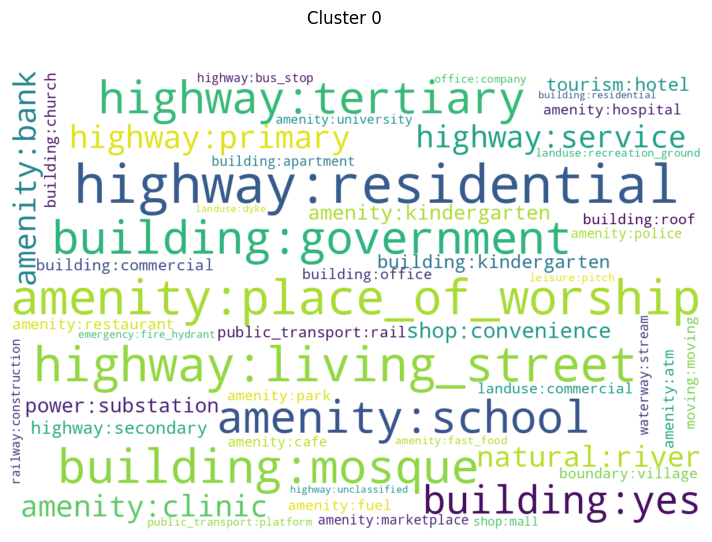

50


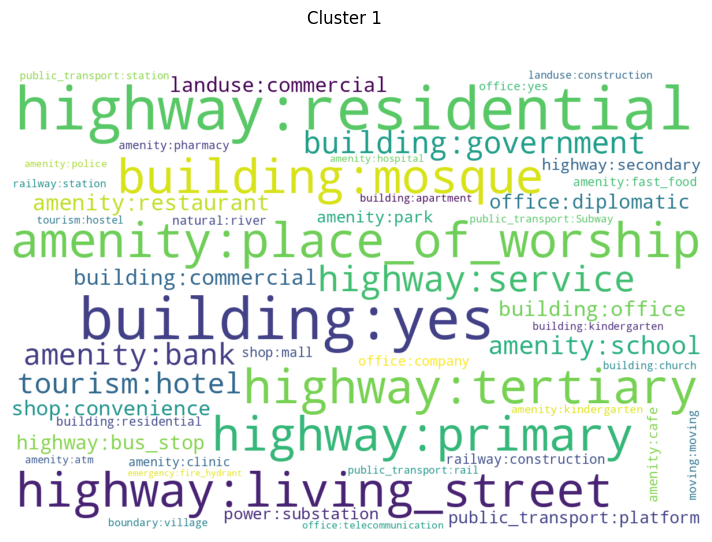

50


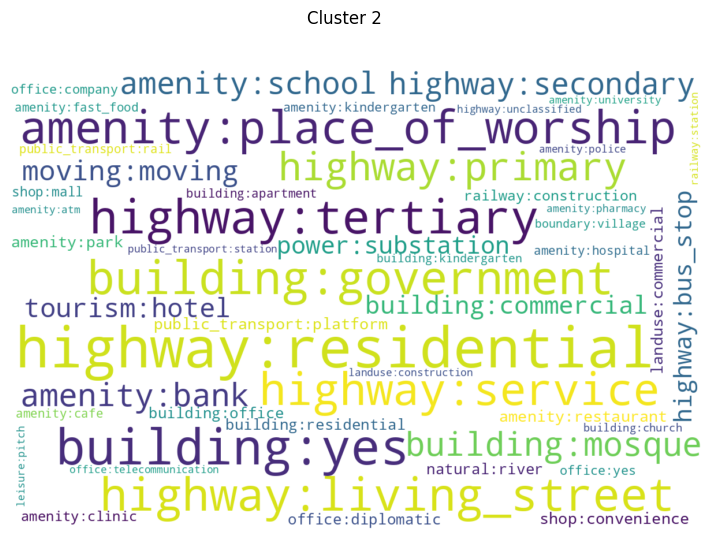

In [161]:
def generate_wordclouds(X, in_X_tfidf, k, in_word_positions):
    # Clustering
    in_model = KMeans(n_clusters=k, random_state=42)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    # Number of words with highest tfidf score to display
    top_count = 50

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        print(len(term_weights))
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        plt.show()

    return in_cluster_ids

_ = generate_wordclouds(pca_vectors, poi_count_array, 3, columns)


## Output file

In [233]:
df.query('pca_label == 1').sample(5).T


imsi,510019110286963,510019710298844,510018760316957,510011610673667,510018810431118
highway:residential,86,77,92,42,58
building:yes,27,19,57,38,40
amenity:place_of_worship,36,4,36,36,6
highway:living_street,17,7,57,36,4
highway:tertiary,60,2,92,42,5
...,...,...,...,...,...
building:retail,0,0,0,7,2
landuse:industrial,14,0,0,0,0
sport:tennis,0,0,0,1,0
pca_label,1,1,1,1,1


In [ ]:
df.to_csv('../output/out.csv')

In [94]:
cluster = 0
kmeans = KMeans(n_clusters= 30, random_state=0, n_init="auto").fit(pca_vectors)
kmean_labels = kmeans.labels_
df['pca_label'] = kmean_labels
df.query(f'pca_label == {cluster}').drop(['pca_label', 'pca_label_1'], axis= 1).sample(5).style\
    .background_gradient(cmap='bwr_r', axis= 1)

# tourism:information  amenity:community_centre shop:laundry (not) building:residential (traveler)

,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,amenity:bank,tourism:hotel,highway:secondary,shop:convenience,building:commercial,power:substation,amenity:restaurant,natural:river,amenity:clinic,landuse:commercial,building:office,amenity:park,highway:bus_stop,public_transport:platform,amenity:kindergarten,office:diplomatic,railway:construction,amenity:cafe,building:residential,shop:mall,building:kindergarten,office:company,amenity:fast_food,public_transport:rail,building:church,boundary:village,building:apartment,amenity:atm,amenity:hospital,office:yes,amenity:police,amenity:pharmacy,public_transport:station,railway:station,landuse:construction,amenity:university,leisure:pitch,highway:unclassified,amenity:fuel,building:roof,amenity:marketplace,emergency:fire_hydrant,tourism:hostel,office:telecommunication,public_transport:Subway,landuse:dyke,amenity:parking,amenity:post_office,amenity:grave_yard,landuse:recreation_ground,man_made:tower,amenity:college,building:construction,amenity:food_court,landuse:pumping_station,shop:bakery,amenity:cinema,shop:supermarket,waterway:stream,office:educational_institution,building:train_station,amenity:bar,building:museum,shop:hairdresser,boundary:military,shop:laundry,public_transport:stop_position,historic:monument,natural:water,building:sports_centre,highway:path,railway:stop,sport:futsal,office:ngo,highway:footway,sport:soccer,shop:department_store,shop:car,amenity:bus_station,amenity:community_centre,tourism:yes,amenity:fire_station,emergency:yes,sport:multi,highway:motorway,shop:dry_cleaning,building:retail,landuse:industrial,sport:tennis,tourism:information
510019860149883,-0.336191,0.123154,-0.126085,0.267641,0.119735,-0.386734,-0.120638,0.148737,0.444107,0.099203,0.568043,0.906913,-0.057658,0.555572,-0.090507,1.051550,1.060300,-0.871218,0.498324,0.337695,1.012764,-0.026483,-0.236049,-0.213924,-0.654656,-0.149834,1.540019,1.437793,-0.754273,-0.294319,-0.527556,0.872424,0.109346,-0.437596,-0.355981,1.367658,-0.314866,1.603217,-0.594426,-0.262381,-0.766096,-0.214135,-0.538216,-0.533588,-0.622522,-0.200816,-0.475814,-0.491753,-0.408580,-0.390242,-0.534591,2.157366,2.165863,2.051493,-0.506865,-0.319247,-0.169064,0.632841,-0.425805,-0.229914,-0.526068,-0.196878,0.120115,0.613861,-0.367137,-0.169439,0.339836,-0.240796,-0.395350,-0.325143,-0.201559,2.705038,-0.392683,3.144018,-0.421289,3.175321,-0.466918,-0.168867,-0.252297,-0.353930,0.136363,-0.454960,-0.234959,2.136054,-0.442728,-0.298381,0.386312,0.014516,-0.448241,1.821780,0.403345,-0.277700,-0.172089,-0.300335,0.364313,3.440429,-0.268385,0.098747,-0.382539,3.797514
510011910011903,0.558295,1.098400,1.017399,0.985425,0.985535,1.150861,0.966630,1.149672,1.460318,0.772618,1.616927,1.850901,1.989383,1.788471,1.959793,2.026516,2.275040,-0.612015,-0.800706,-0.060566,-0.083862,2.343190,2.427654,2.445527,1.785149,2.361366,2.664294,2.888857,-0.849405,2.525949,1.980718,2.424901,3.008552,-0.697895,2.341567,-0.760187,-0.743738,-0.377402,-0.840964,-0.819480,-0.432767,0.342367,-0.798593,-0.794798,-0.428851,-0.731203,-0.670085,-0.491753,-0.543056,-0.524140,-0.678593,3.827454,3.730940,-0.431805,-0.260610,-0.595367,-0.169064,4.831191,-0.497969,-0.472804,-0.526068,-0.501631,4.752951,5.045103,-0.543435,-0.082023,5.183155,-0.508393,-0.395350,-0.038173,-0.465642,0.237636,-0.486252,5.599022,-0.339232,5.732023,-0.466918,-0.266273,-0.443857,-0.451888,-0.432110,-0.454960,-0.425419,-0.213043,-0.442728,-0.401888,6.014001,-0.412489,-0.448241,7.407182,-0.064872,-0.277700,-0.409300,-0.422990,-0.337515,-0.240304,-0.386661,-0.390415,-0.382539,6.609444
510016260870792,0.040434,0.587557,0.486496,0.546779,-0.789355,0.681040,0.563938,-0.504047,0.906021,-0.784654,1.024080,1.293090,1.161856,-0.266360,-0.546129,1.539033,1.527507,-1.000819,-0.128794,0.381947,0.631329,0.022885,-0.395871,-0.373491,-0.936172,-0.789944,1.931072,2.059678,-0.849405,-0.7

In [95]:
cluster = 1
kmeans = KMeans(n_clusters= 30, random_state=0, n_init="auto").fit(pca_vectors)
kmean_labels = kmeans.labels_
df['pca_label'] = kmean_labels
df.query(f'pca_label == {cluster}').drop(['pca_label', 'pca_label_1'], axis= 1).sample(5).style\
    .background_gradient(cmap='bwr_r', axis= 1)

# amenity:university	 sport:futsal  emergency:yes (not) building:kindergarten (student?)


,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,amenity:bank,tourism:hotel,highway:secondary,shop:convenience,building:commercial,power:substation,amenity:restaurant,natural:river,amenity:clinic,landuse:commercial,building:office,amenity:park,highway:bus_stop,public_transport:platform,amenity:kindergarten,office:diplomatic,railway:construction,amenity:cafe,building:residential,shop:mall,building:kindergarten,office:company,amenity:fast_food,public_transport:rail,building:church,boundary:village,building:apartment,amenity:atm,amenity:hospital,office:yes,amenity:police,amenity:pharmacy,public_transport:station,railway:station,landuse:construction,amenity:university,leisure:pitch,highway:unclassified,amenity:fuel,building:roof,amenity:marketplace,emergency:fire_hydrant,tourism:hostel,office:telecommunication,public_transport:Subway,landuse:dyke,amenity:parking,amenity:post_office,amenity:grave_yard,landuse:recreation_ground,man_made:tower,amenity:college,building:construction,amenity:food_court,landuse:pumping_station,shop:bakery,amenity:cinema,shop:supermarket,waterway:stream,office:educational_institution,building:train_station,amenity:bar,building:museum,shop:hairdresser,boundary:military,shop:laundry,public_transport:stop_position,historic:monument,natural:water,building:sports_centre,highway:path,railway:stop,sport:futsal,office:ngo,highway:footway,sport:soccer,shop:department_store,shop:car,amenity:bus_station,amenity:community_centre,tourism:yes,amenity:fire_station,emergency:yes,sport:multi,highway:motorway,shop:dry_cleaning,building:retail,landuse:industrial,sport:tennis,tourism:information
510013210012366,0.699530,0.169594,-0.861181,0.187887,0.249605,-0.600288,-0.966291,0.496888,0.813638,-0.574212,-1.620934,-1.066878,-0.885186,1.057864,1.139673,1.295292,-1.135577,-0.352811,-0.755912,-1.034095,1.489559,-1.013847,0.136870,0.158399,-0.983092,0.244079,1.735545,-0.842450,1.671581,1.910618,-0.871828,-0.947722,-0.671210,-0.802015,-0.872533,0.241152,1.990324,-0.773526,2.364024,-0.881380,-0.766096,-0.646970,-0.668404,-0.664193,-0.751636,2.848910,0.625058,-0.355226,-0.677532,-0.591088,-0.534591,-0.604701,-0.588674,-0.569766,-0.568429,-0.595367,1.472271,-0.611115,-0.425805,-0.553768,-0.526068,-0.501631,-0.497597,-0.433524,-0.543435,-0.519100,3.847067,-0.508393,-0.395350,1.205362,-0.465642,-0.443027,-0.486252,-0.363129,-0.421289,-0.439328,-0.466918,-0.461085,-0.443857,-0.353930,-0.432110,-0.454960,1.479175,-0.400971,-0.336668,-0.298381,-0.364047,-0.305738,-0.448241,-0.412380,-0.416035,-0.386803,5.758193,-0.300335,-0.237253,-0.345468,-0.386661,-0.390415,-0.382539,-0.319956
510018710425342,-0.712817,-0.155488,-0.085246,-0.051374,-0.269875,-0.087757,0.040439,-0.634603,0.259341,0.351733,0.385628,-0.251616,-0.057658,-0.312023,-1.092876,-0.800884,0.920137,-0.784817,0.095177,-0.901341,0.297573,1.306458,0.030321,0.052021,-0.513898,0.293318,0.513507,-0.427860,1.100792,-0.858373,-0.724283,1.354227,-0.838472,-0.437596,0.504939,1.805744,-0.422084,-0.547169,1.809314,1.470818,1.433875,0.466035,0.177823,0.184739,0.345832,1.522942,2.243986,-0.423490,-0.610294,-0.390242,2.633454,-0.604701,1.665038,-0.500786,-0.322174,-0.112158,0.221730,1.954543,-0.281476,-0.391841,1.371723,-0.349255,-0.343169,-0.111252,0.073609,-0.256854,-0.495219,-0.508393,-0.253799,-0.229486,-0.289587,-0.443027,-0.486252,-0.450808,-0.421289,-0.263003,-0.074919,-0.461085,0.897069,1.409311,-0.337365,-0.051306,3.764687,-0.400971,0.087574,-0.194874,-0.270252,-0.412489,-0.448241,-0.300672,-0.298981,-0.168598,4.690743,-0.177679,-0.337515,-0.345468,1.269193,-0.390415,-0.262487,-0.319956
510011010007849,-0.242035,0.123154,0.282302,0.227764,0.119735,0.168509,0.322323,0.192256,0.490298,0.393822,0.522439,0.306194,-0.101212,0.555572,0.456240,0.320326,0.873417,-0.396012,0.184765,-0.016315,0.726688,1.108985,0.722884,0.743478,-0.373140,0.687232,0.904560,-0.376037,

In [99]:
cluster = 2
kmeans = KMeans(n_clusters= 30, random_state=0, n_init="auto").fit(pca_vectors)
kmean_labels = kmeans.labels_
df['pca_label'] = kmean_labels
df.query(f'pca_label == {cluster}').drop(['pca_label', 'pca_label_1'], axis= 1).sample(5).style\
    .background_gradient(cmap='bwr_r', axis= 1)
# public_transport:Subway railway:station  public_transport:Subway (worker)

,highway:residential,building:yes,amenity:place_of_worship,highway:living_street,highway:tertiary,building:government,building:mosque,highway:primary,highway:service,amenity:school,amenity:bank,tourism:hotel,highway:secondary,shop:convenience,building:commercial,power:substation,amenity:restaurant,natural:river,amenity:clinic,landuse:commercial,building:office,amenity:park,highway:bus_stop,public_transport:platform,amenity:kindergarten,office:diplomatic,railway:construction,amenity:cafe,building:residential,shop:mall,building:kindergarten,office:company,amenity:fast_food,public_transport:rail,building:church,boundary:village,building:apartment,amenity:atm,amenity:hospital,office:yes,amenity:police,amenity:pharmacy,public_transport:station,railway:station,landuse:construction,amenity:university,leisure:pitch,highway:unclassified,amenity:fuel,building:roof,amenity:marketplace,emergency:fire_hydrant,tourism:hostel,office:telecommunication,public_transport:Subway,landuse:dyke,amenity:parking,amenity:post_office,amenity:grave_yard,landuse:recreation_ground,man_made:tower,amenity:college,building:construction,amenity:food_court,landuse:pumping_station,shop:bakery,amenity:cinema,shop:supermarket,waterway:stream,office:educational_institution,building:train_station,amenity:bar,building:museum,shop:hairdresser,boundary:military,shop:laundry,public_transport:stop_position,historic:monument,natural:water,building:sports_centre,highway:path,railway:stop,sport:futsal,office:ngo,highway:footway,sport:soccer,shop:department_store,shop:car,amenity:bus_station,amenity:community_centre,tourism:yes,amenity:fire_station,emergency:yes,sport:multi,highway:motorway,shop:dry_cleaning,building:retail,landuse:industrial,sport:tennis,tourism:information
510013160306114,1.499859,1.980766,1.834172,1.743086,1.721465,1.449837,1.852551,0.714483,0.120767,2.077359,0.340024,2.537437,-0.623861,2.838717,0.684051,-1.190870,2.648806,-0.352811,2.021325,0.072188,0.679008,-0.223956,-0.022953,-0.001168,-0.983092,-0.149834,-0.024190,-0.427860,2.575331,-0.601985,-0.871828,0.444155,-0.503948,-0.802015,3.432066,3.120001,-0.100429,0.528024,-0.224620,-0.509980,-0.366101,3.434048,1.544807,1.556091,1.120515,0.263273,-0.540571,0.941783,0.868940,0.881784,-0.102585,-0.604701,3.480528,-0.431805,1.770992,-0.043128,0.378048,-0.144632,-0.497969,-0.553768,4.534707,0.336438,-0.420383,-0.514092,1.395846,-0.344269,-0.328208,-0.508393,-0.395350,-0.420800,-0.465642,-0.443027,-0.486252,-0.450808,-0.421289,0.530456,1.297076,-0.461085,1.375972,-0.451888,-0.337365,1.361484,-0.330189,-0.400971,1.572421,-0.401888,-0.176457,-0.305738,1.297728,-0.412380,-0.064872,-0.386803,0.539545,-0.422990,-0.337515,-0.240304,1.032642,-0.390415,-0.262487,-0.319956
510018610004751,-0.854052,-0.480570,-0.371117,-0.290635,-0.269875,-0.557578,-0.281715,-0.068857,-0.341147,-0.195416,0.112006,0.134560,-0.928740,-0.403349,0.592926,0.466571,0.733254,0.165595,0.050383,0.558952,-0.322259,-0.273324,0.349966,0.371155,-0.795414,0.145601,-0.757412,-0.272389,1.005660,0.936344,-0.822647,1.086559,-0.503948,-0.593776,-0.298586,0.053401,0.757316,0.075311,1.131336,1.161318,1.100546,0.837036,0.568390,0.576554,0.668617,1.788136,0.754572,0.122619,0.263799,0.279245,0.761428,-0.604701,1.164213,1.085766,1.647864,-0.181187,-0.481699,1.643554,-0.353640,0.093940,0.739126,1.479259,-0.265955,-0.514092,0.338056,0.180223,-0.328208,-0.419194,-0.395350,-0.038173,-0.465642,0.492884,-0.205545,1.215087,-0.421289,0.354132,1.591075,-0.266273,-0.252297,-0.255972,-0.337365,1.664225,0.431649,-0.400971,0.829998,-0.401888,-0.364047,0.014516,0.715738,-0.300672,2.510324,-0.168598,0.183728,0.680911,-0.237253,-0.345468,-0.150110,-0.145834,-0.382539,-0.319956
510011810815708,-0.948208,-0.387690,-0.493633,-0.450143,-0.269875,-0.301312,-0.362253,-0.025339,-0.063999,0.015026,0.157610,0.306194,-1.102956,-0.905640,0.729613,-0.898380,-0.668369,-0.871218,0.677501,0.735957,-0.083862,-0.618902,-0.662241,-0.639436,-0.936172,0.194840,-0.806294,-0.686979,0.910529,-0.191764

## Messy code

In [ ]:
# import matplotlib.pyplot as plt
# total = df['pca_label'].value_counts().values.sum()

# def fmt(x):
#     return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

# plt.pie(df['pca_label'].value_counts().values, labels=df['pca_label'].value_counts().index, autopct=fmt)

# sns.scatterplot(x='sport:basketball',y='building:civic',hue='pca_label',palette=sns.color_palette("hls",10),data=df,
#                legend="full")





# pca_df = pd.DataFrame(pca_vectors, columns=['pca1', 'pca2'])
# sns.scatterplot(x='pca1',y='pca2',palette=sns.color_palette("hls",10),data=pca_df,
#                legend="full")

# pca_df = pd.DataFrame(poi_to_pca_vector, columns=['pca1', 'pca2'])
# sns.scatterplot(x='pca1',y='pca2',palette=sns.color_palette("hls",10),data=pca_df,
#                legend="full")




# most_similar += [user_to_see]
similar = df[df.index.isin(most_similar)]
tmp = np.var(similar, axis=0)
# tmp[tmp> 100].sort_values(ascending=False)

# reverse_similar += [user_to_see]
not_most_similar =  df[df.index.isin(reverse_similar)]
tmp1 = np.var(not_most_similar, axis=0)
# tmp1[tmp1> 100].sort_values(ascending=False)

z = pd.DataFrame([tmp, tmp1]).T.head(100)
z = pd.DataFrame([tmp, tmp1]).T.sort_values(by= 0, ascending=False).head(100)

sns.lineplot(data= z, x= z.index, y= 0)
sns.lineplot(data= z, x= z.index, y= 1)